In [3]:
from hashlib import sha256
import base64
from Crypto import Random
from Crypto.Cipher import AES
import pandas as pd
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.serialization import load_pem_private_key
from cryptography.hazmat.primitives.serialization import load_pem_public_key
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.exceptions import InvalidSignature
from cryptography.hazmat.primitives import hashes
from PIL import Image
import stepic

def gen_key():
    private_key = rsa.generate_private_key(
        public_exponent=65537, key_size=2048, backend=default_backend())

    public_key = private_key.public_key()
    return private_key, public_key


def save_pvkey(pk, filename):
    pem = pk.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    )
    with open(filename, 'wb') as pem_out:
        pem_out.write(pem)

def save_pukey(pk, filename):
    pem = pk.public_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    with open(filename, 'wb') as pem_out:
        pem_out.write(pem)

private_key, public_key = gen_key()

save_pvkey(private_key, 'private_key')
save_pukey(public_key, 'public_key')
print("Private key and Public key generated.")

Private key and Public key generated.


In [4]:
import random

def generate_alphabet_data(num_bits):
    # Generate random alphabet data
    alphabet_data = ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ') for _ in range(num_bits))

    return alphabet_data

# Specify the number of bits
alpha = 200

# Generate alphabet data
alphabet_data = generate_alphabet_data(alpha)

# Print the result
print(f"Generated Alphabet Data: {alphabet_data}")


Generated Alphabet Data: HCAYIHIUEXPZGNQBJHAXUCRRIYSNIFRRSJPACHOKOVOYRGOYIWXYHTNJMAKSFDLTVHPCKGKBPMURBJMXECVWVHGFJDXMMKBYFJHEGRZEFSYVPOVMRLITKCCESBZPMNNFTZRKKUQLLVFUBFLJEWEMRHEKBFCWYCXQZNEUJOPEHUHXOCSAHCMOTTNJYAWWFEEGMHJNMLZD


In [5]:
DNA_data = { "words":["A","B","C","D","E","F","G","H","I","J","K","L","M","N",
                      "O","P","Q","R","S","T","U","V","W","X","Y","Z"," ",",",
                      ".",":","0","1","2","3","4","5","6","7","8","9"],
            "DNA_code": ["CGA","CCA","GTT","TTG","GGC","GGT","TTT","CGC","ATG",
                         "AGT","AAG","TGC","TCC","TCT","GGA","GTG","AAC","TCA",
                         "ACG","TTC","CTG","CCT","CCG","CTA","AAA","CTT","ACC",
                         "TCG","GAT","GCT","ACT","TAG","ATA","GCA","GAG","AGA",
                         "TTA","ACA","AGG","GCG"]
           }

DNA_df = pd.DataFrame.from_dict(DNA_data)
# DNA_df
message = input("Please Enter your Message: ")
DNA_crypto_message = ""
word = message.upper()

for i in word:
    DNA_crypto_message+= str(DNA_df.loc[ DNA_df['words'] == i , 'DNA_code' ].iloc[0])

print(DNA_crypto_message)

Please Enter your Message: too much work to do
TTCGGAGGAACCTCCCTGGTTCGCACCCCGGGATCAAAGACCTTCGGAACCTTGGGA


In [6]:
BS = 16
pad = lambda s: bytes(s + (BS - len(s) % BS) * chr(BS - len(s) % BS), 'utf-8')
unpad = lambda s : s[0:-ord(s[-1:])]

class AESCipher:

    def __init__( self, key ):
        self.key = bytes(key, 'utf-8')

    def encrypt( self, raw ):
        raw = pad(raw)
        iv = Random.new().read( AES.block_size )
        cipher = AES.new(self.key, AES.MODE_CBC, iv )
        return base64.b64encode( iv + cipher.encrypt( raw ) )

cipher = AESCipher('LKHlhb899Y09olUi')
AES_encrypted_message = cipher.encrypt(DNA_crypto_message)

print(AES_encrypted_message)

b'2WUEO9fmu6aWZwsHLWQ559H2/wvF/HFyH8aG+DHwKU6uUE9vk1dTJa0GSn+NOd1bicyapyDqF7xjIhpr3LLg3Mhi5+2AemGKSer3GRqxIG8='


In [7]:
def load_pvkey(filename):
    with open(filename, 'rb') as pem_in:
        pemlines = pem_in.read()

    private_key = load_pem_private_key(pemlines, None, default_backend())
    return private_key

message = AES_encrypted_message
private_key = load_pvkey("private_key")
signature = private_key.sign(message, padding.PSS(mgf=padding.MGF1(hashes.SHA256()),
                                                  salt_length=padding.PSS.MAX_LENGTH),hashes.SHA256())
# signature

In [9]:
im = Image.open('/content/monster.png')
#Encode some text into your Image file and save it in another file
secret_msg = AES_encrypted_message + bytes("SIGNATURE", 'utf-8') + signature

im1 = stepic.encode(im, secret_msg)
im1.save('/content/encrypted.png', 'PNG')

In [10]:
im = Image.open('/content/encrypted.png')
stegoImage = stepic.decode(im)

ind_sep = stegoImage.find('SIGNATURE')
message = bytes(stegoImage[:ind_sep],'utf-8')
signature = bytes(stegoImage[ind_sep+9:], 'latin1')

In [11]:
def load_pukey(filename):
    with open(filename, 'rb') as pem_in:
        pemlines = pem_in.read()
    public_key = load_pem_public_key(pemlines, default_backend())
    return public_key

public_key = load_pukey("public_key")
try:
    public_key.verify(signature, message, padding.PSS(mgf=padding.MGF1(hashes.SHA256()),
                                                  salt_length=padding.PSS.MAX_LENGTH),hashes.SHA256())
    print(message)
except InvalidSignature:
    print('Invalid!')

b'2WUEO9fmu6aWZwsHLWQ559H2/wvF/HFyH8aG+DHwKU6uUE9vk1dTJa0GSn+NOd1bicyapyDqF7xjIhpr3LLg3Mhi5+2AemGKSer3GRqxIG8='


In [12]:
BS = 16
pad = lambda s: bytes(s + (BS - len(s) % BS) * chr(BS - len(s) % BS), 'utf-8')
unpad = lambda s : s[0:-ord(s[-1:])]

class AESCipher:

    def __init__( self, key ):
        self.key = bytes(key, 'utf-8')

    def decrypt( self, enc ):
        enc = base64.b64decode(enc)
        iv = enc[:16]
        cipher = AES.new(self.key, AES.MODE_CBC, iv )
        return unpad(cipher.decrypt( enc[16:] )).decode('utf8')

cipher = AESCipher('LKHlhb899Y09olUi')
AES_decrypted = cipher.decrypt(message)

print(AES_decrypted)

TTCGGAGGAACCTCCCTGGTTCGCACCCCGGGATCAAAGACCTTCGGAACCTTGGGA


In [13]:
DNA_data = { "words":["A","B","C","D","E","F","G","H","I","J","K","L","M","N",
                      "O","P","Q","R","S","T","U","V","W","X","Y","Z"," ",",",
                      ".",":","0","1","2","3","4","5","6","7","8","9"],
            "DNA_code": ["CGA","CCA","GTT","TTG","GGC","GGT","TTT","CGC","ATG",
                         "AGT","AAG","TGC","TCC","TCT","GGA","GTG","AAC","TCA",
                         "ACG","TTC","CTG","CCT","CCG","CTA","AAA","CTT","ACC",
                         "TCG","GAT","GCT","ACT","TAG","ATA","GCA","GAG","AGA",
                         "TTA","ACA","AGG","GCG"]
           }

DNA_df = pd.DataFrame.from_dict(DNA_data)

l = [AES_decrypted[i:i+3] for i in range(0, len(AES_decrypted), 3)]

original_message = ""
for i in l:
    original_message+= str(DNA_df.loc[ DNA_df['DNA_code'] == i , 'words' ].iloc[0])
print("The secret message is: ",original_message.lower())

The secret message is:  too much work to do


Metric Value: 0.9714718956470556


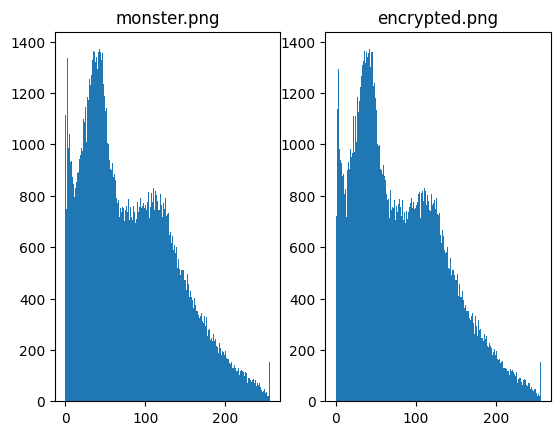

In [14]:
# import required libraries
import cv2
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('/content/monster.png')
img2 = cv2.imread('/content/encrypted.png')

# Calculate the histograms, and normalize them
hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
print("Metric Value:", metric_val)

# plot the histograms of two images
plt.subplot(121), plt.hist(img1.ravel(),256,[0,256]),
plt.title('monster.png')
plt.subplot(122), plt.hist(img2.ravel(),256,[0,256]),
plt.title('encrypted.png')
plt.show()

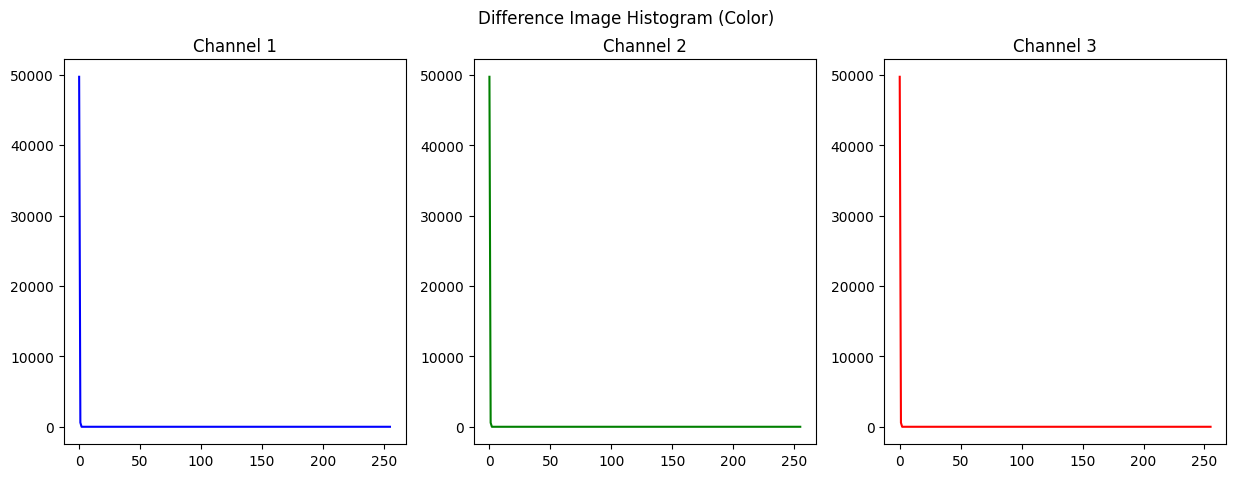

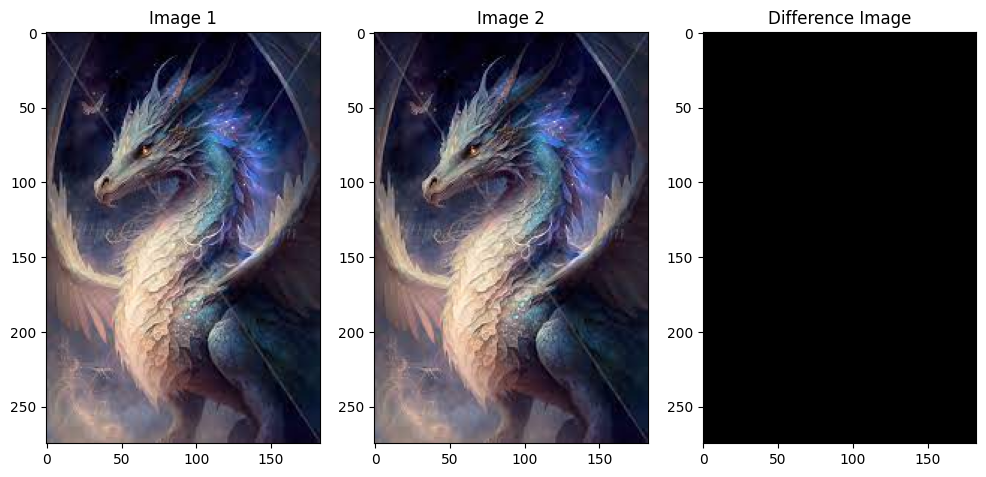

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_difference_histogram_color(image1_path, image2_path):
    # Read the color images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Ensure both images have the same size
    height, width, _ = img1.shape
    img2 = cv2.resize(img2, (width, height))

    # Calculate the absolute difference between the two images
    diff_img = cv2.absdiff(img1, img2)

    # Generate a histogram of the differences for each color channel
    hist_channels = []
    for c in range(3):  # Iterate over RGB channels
        hist = cv2.calcHist([diff_img], [c], None, [256], [0, 256])
        hist_channels.append(hist)

    # Plot the histograms for each color channel
    plt.figure(figsize=(15, 5))
    for c in range(3):  # Iterate over RGB channels
        plt.subplot(1, 3, c + 1)
        plt.plot(hist_channels[c], color=['blue', 'green', 'red'][c])
        plt.title(f'Channel {c + 1}')

    plt.suptitle('Difference Image Histogram (Color)')
    plt.show()

    # Display the original images and the difference image using Matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(131), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Image 1')
    plt.subplot(132), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Image 2')
    plt.subplot(133), plt.imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB)), plt.title('Difference Image')

    plt.show()

# Example usage
image1_path = "/content/monster.png"
image2_path = "/content/encrypted.png"

generate_difference_histogram_color(image1_path, image2_path)


In [16]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(original_image, stego_image):
    return psnr(original_image, stego_image)

def calculate_ssim(original_image, stego_image):
    return ssim(original_image, stego_image, multichannel=True)

def calculate_absolute_difference(image1_path, image2_path):
    # Read the images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Ensure both images have the same size
    height, width, _ = img1.shape
    img2 = cv2.resize(img2, (width, height))

    # Calculate the absolute difference
    abs_diff = cv2.absdiff(img1, img2)


    # Calculate the sum of absolute differences (SAD)
    sad_value = np.sum(abs_diff)

    return sad_value


def main():
    # Load the original image
    original_image_path = "/content/monster.png"
    original_image = cv2.imread(original_image_path)

    # Save or display the stego-image
    stego_image_path = "/content/encrypted.png"
    stego_image = cv2.imread(stego_image_path)

    # Calculate and print performance metrics
    psnr_value = calculate_psnr(original_image, stego_image)
    ssim_value = calculate_ssim(original_image, stego_image)

    numeric_difference = calculate_absolute_difference(original_image_path, stego_image_path)
    print(f"Sum of Absolute Differences (SAD): {numeric_difference}")
    print(f"PSNR: {psnr_value} dB")
    print(f"SSIM: {ssim_value}")

if __name__ == "__main__":
    main()


Sum of Absolute Differences (SAD): 1740
PSNR: 67.51436150865665 dB
SSIM: 0.9999293777773438


<ipython-input-16-7690ccf4c4d6>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(original_image, stego_image, multichannel=True)


In [17]:
import cv2
import numpy as np

def calculate_mse(original_image, stego_image):
    # Ensure both images have the same size
    height, width = original_image.shape[:2]
    stego_image = cv2.resize(stego_image, (width, height))

    # Calculate MSE
    mse = np.mean((original_image - stego_image)**2)
    return mse

def main(original_image_path, stego_image_path):
    # Read the original and stego images
    original_img = cv2.imread(original_image_path)
    stego_img = cv2.imread(stego_image_path)

    # Calculate the MSE for the entire color image
    mse_value = calculate_mse(original_img, stego_img)

    print(f"Mean Squared Error (MSE): {mse_value:.6f}")

# Example usage
original_image_path = "/content/monster.png"
stego_image_path = "/content/encrypted.png"

main(original_image_path, stego_image_path)


Mean Squared Error (MSE): 0.011525


In [18]:
import hashlib
from PIL import Image

def calculate_hash(file_path, hash_function=hashlib.sha256):
    # Open the file in binary mode
    with open(file_path, 'rb') as file:
        # Read the content of the file
        file_content = file.read()

        # Calculate the hash of the file content
        hash_object = hash_function(file_content)
        hash_hex = hash_object.hexdigest()

    return hash_hex

def main():
    # Replace these paths with the paths to your original and stego images
    original_image_path = '/content/monster.png'
    stego_image_path = '/content/encrypted.png'

    # Calculate hashes for the original and stego images
    original_hash = calculate_hash(original_image_path)
    stego_hash = calculate_hash(stego_image_path)

    # Printing the hashes
    print("Original Hash:",original_hash)
    print("Stego Hash:   ",stego_hash)

    # Compare the hashes
    if original_hash == stego_hash:
        print("Hashes match. The stego image may be reversible.")
    else:
        print("Hashes do not match. The stego image is different from the original.")

if __name__ == "__main__":
    main()


Original Hash: 6737e679311db1514a83d94718b868f114581b715ffd0e37de69368663f770bc
Stego Hash:    fe3c61589b7b718923012163de7cd58dfab8da8604ce82df666853143d6afc46
Hashes do not match. The stego image is different from the original.
